# Import Libraries

In [1]:
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('whitegrid')
plt.style.use("fivethirtyeight")

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error,mean_absolute_error

import keras
from keras.models import Sequential
from keras.callbacks import EarlyStopping
from keras.layers import Dense, LSTM, Dropout

import warnings
warnings.filterwarnings('ignore')

# Explore Data

In [2]:
data_dir = '/kaggle/input/tesla-stock-data-updated-till-28jun2021/TSLA.csv'
data = pd.read_csv(data_dir, parse_dates= True , index_col= "Date")

In [3]:
data.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-06-29,3.800,5.000,3.508,4.778,4.778,93831500
2010-06-30,5.158,6.084,4.660,4.766,4.766,85935500
2010-07-01,5.000,5.184,4.054,4.392,4.392,41094000
2010-07-02,4.600,4.620,3.742,3.840,3.840,25699000
2010-07-06,4.000,4.000,3.166,3.222,3.222,34334500


In [4]:
data.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2022-03-18,874.489990,907.849976,867.390015,905.390015,905.390015,33408500
2022-03-21,914.979980,942.849976,907.090027,921.159973,921.159973,27327200
2022-03-22,930.000000,997.859985,921.750000,993.979980,993.979980,35289500
2022-03-23,979.940002,1040.699951,976.400024,999.109985,999.109985,40225400
2022-03-24,1009.729980,1024.489990,988.799988,1013.919983,1013.919983,22901900


In [5]:
data.describe()

,Open,High,Low,Close,Adj Close,Volume
count,2956.000000,2956.000000,2956.000000,2956.000000,2956.000000,2.956000e+03
mean,138.691296,141.771603,135.425953,138.762183,138.762183,3.131449e+07
std,250.044839,255.863239,243.774157,250.123115,250.123115,2.798383e+07
min,3.228000,3.326000,2.996000,3.160000,3.160000,5.925000e+05
25%,19.627000,20.402000,19.127500,19.615000,19.615000,1.310288e+07
50%,46.656999,47.487001,45.820002,46.545000,46.545000,2.488680e+07
75%,68.057001,69.357500,66.911501,68.103998,68.103998,3.973875e+07
max,1234.410034,1243.489990,1217.000000,1229.910034,1229.910034,3.046940e+08


In [6]:
data.shape

(2956, 6)

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2956 entries, 2010-06-29 to 2022-03-24
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       2956 non-null   float64
 1   High       2956 non-null   float64
 2   Low        2956 non-null   float64
 3   Close      2956 non-null   float64
 4   Adj Close  2956 non-null   float64
 5   Volume     2956 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 161.7 KB


# Data Analysis

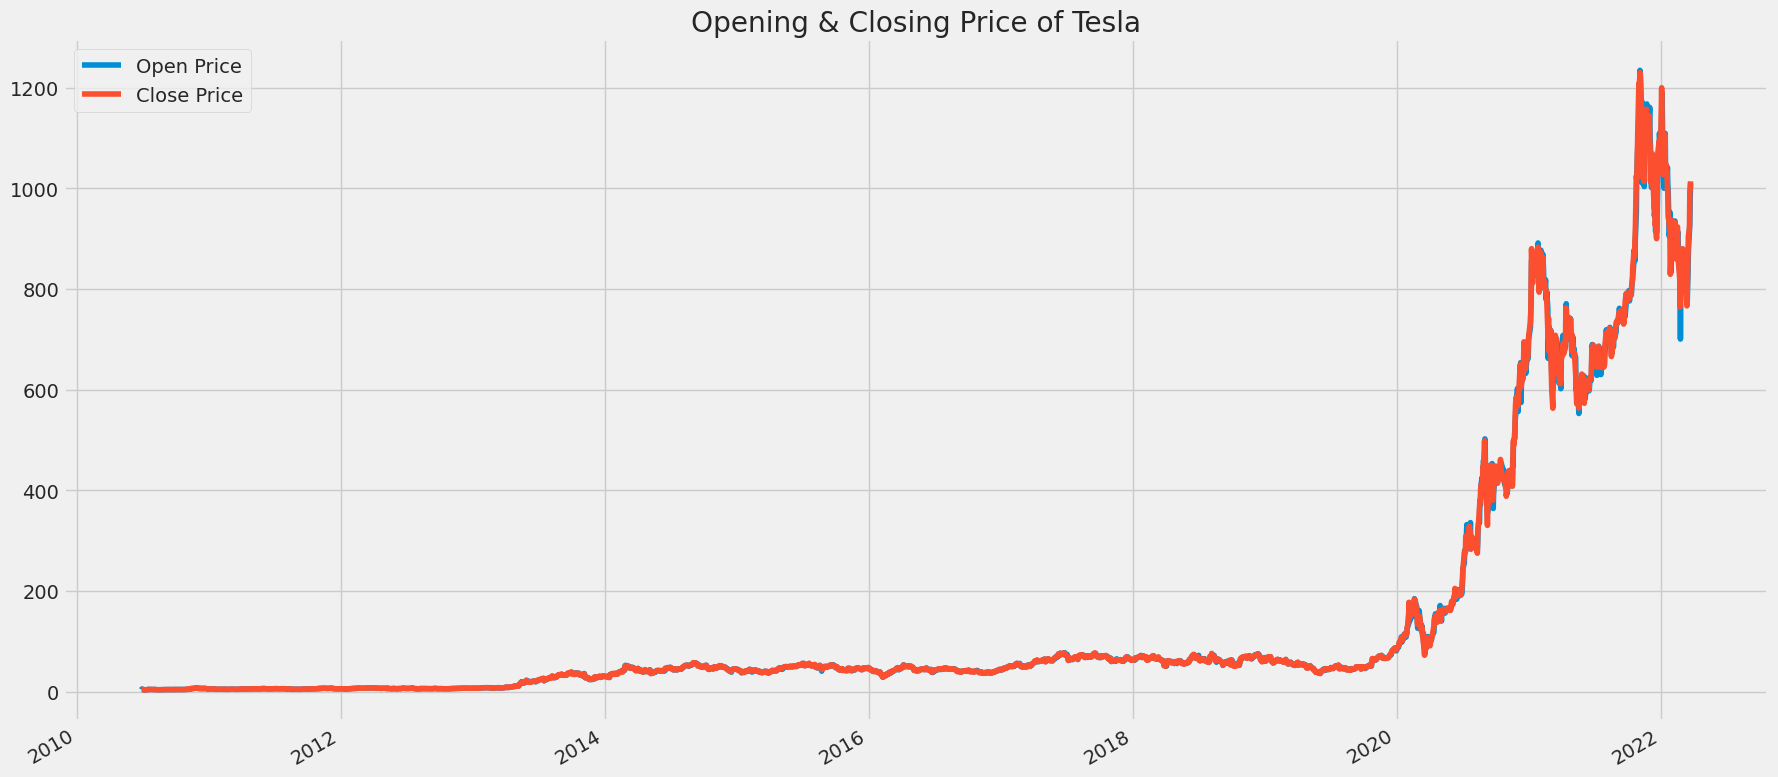

In [8]:
plt.figure(figsize=(18, 8))
data['Open'].plot()
data['Close'].plot()
plt.ylabel(None)
plt.xlabel(None)
plt.title("Opening & Closing Price of Tesla")
plt.legend(['Open Price', 'Close Price'])
plt.tight_layout()
plt.show()

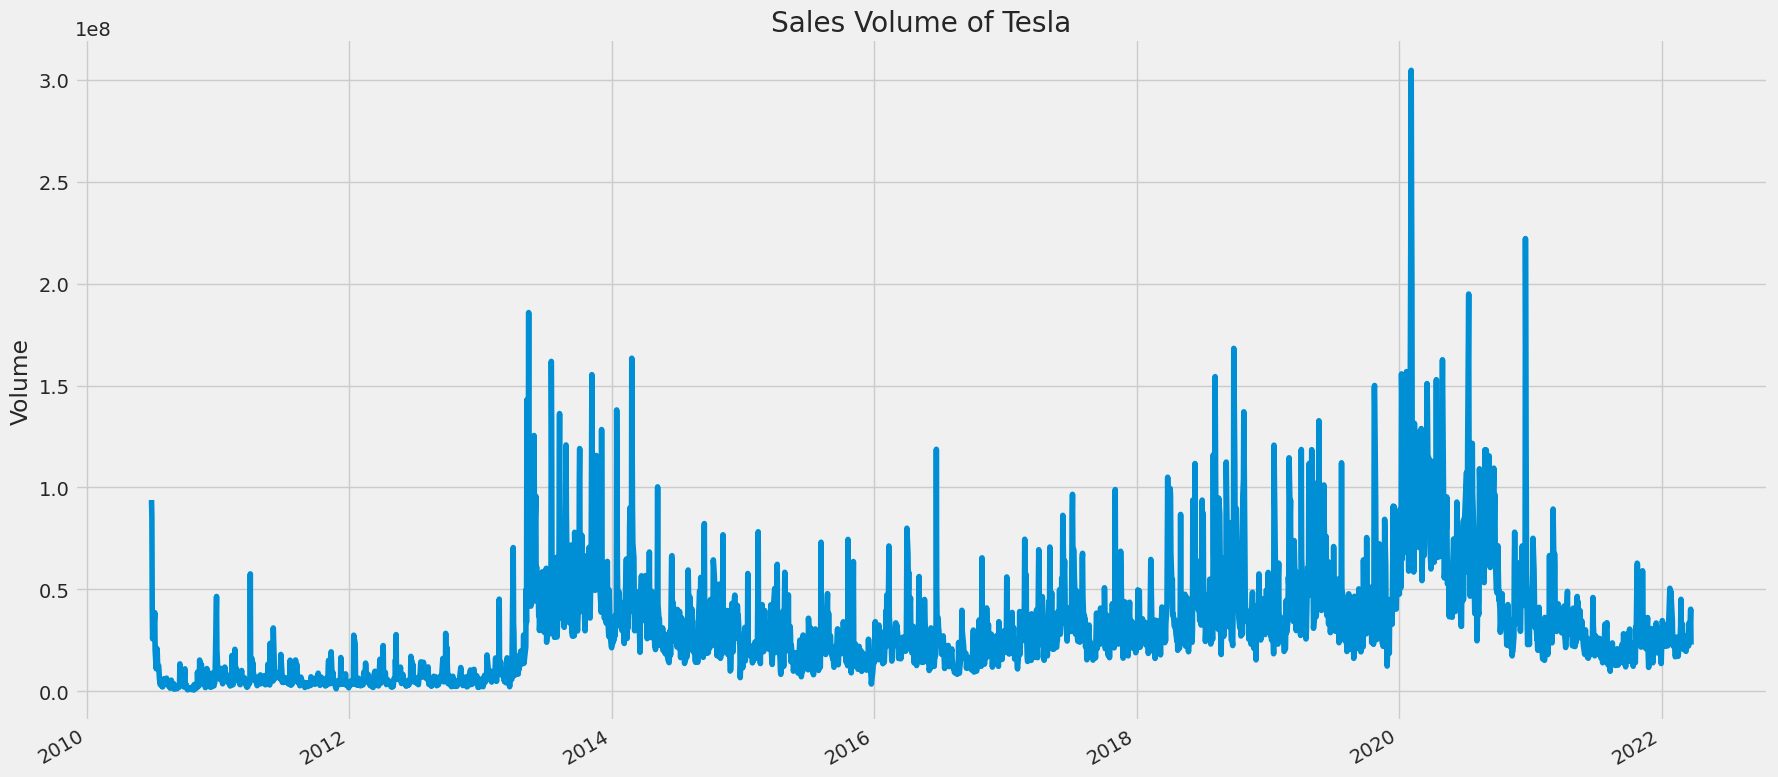

In [9]:
plt.figure(figsize=(18, 8))
data['Volume'].plot()
plt.ylabel('Volume')
plt.xlabel(None)
plt.title("Sales Volume of Tesla")
plt.tight_layout()
plt.show()

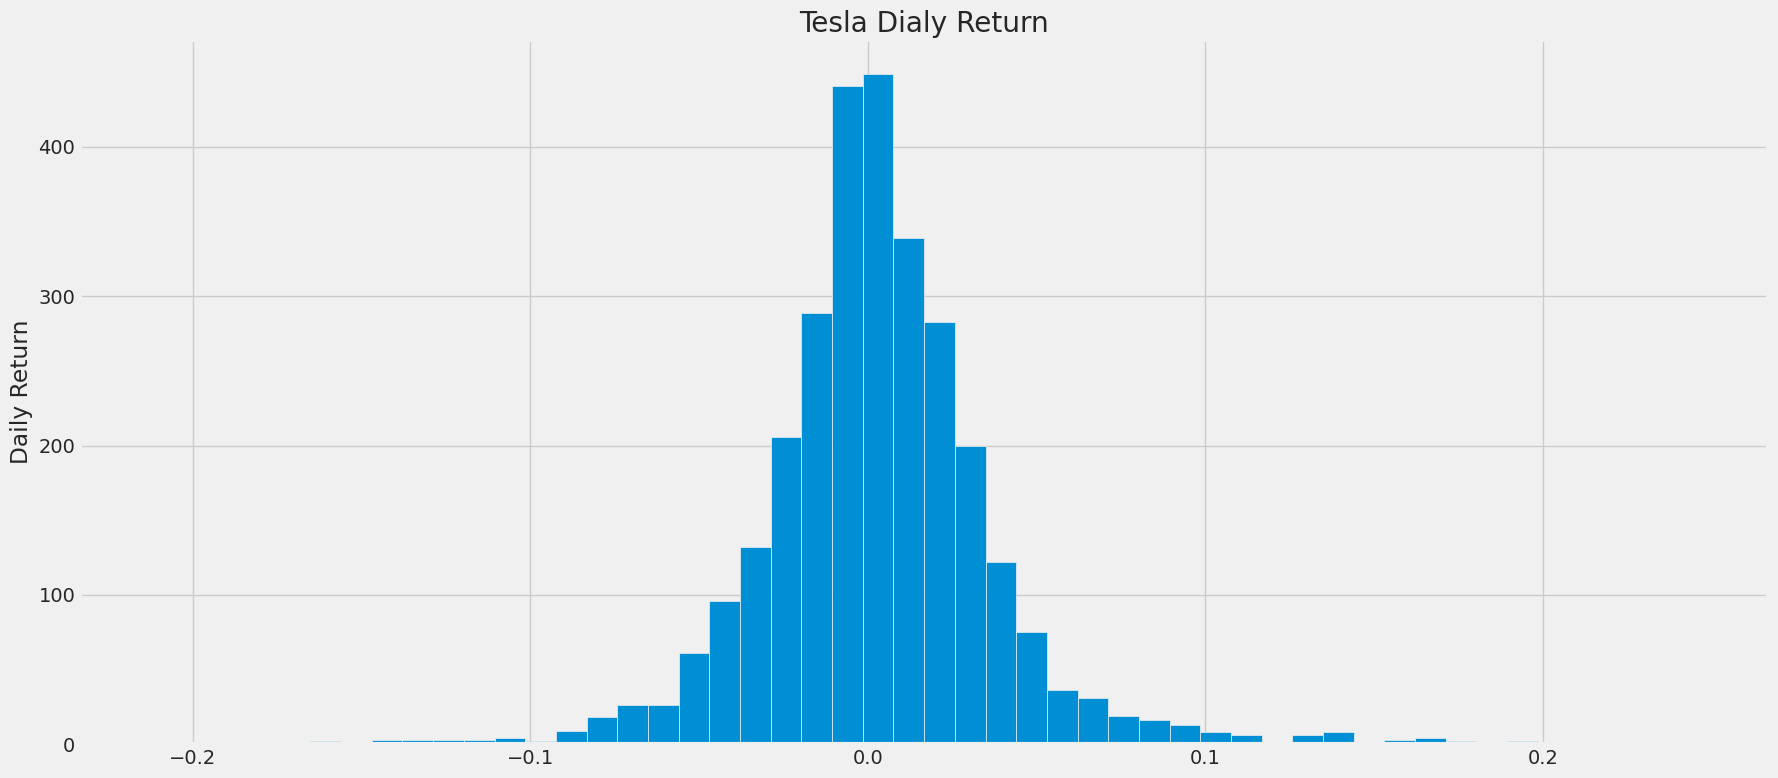

In [10]:
plt.figure(figsize=(18, 8))
data['Adj Close'].pct_change().hist(bins=50)
plt.ylabel('Daily Return')
plt.title(f'Tesla Dialy Return')
plt.tight_layout()
plt.show()

# Data Preprocessing

### Choosing Prediction Column

In [11]:
df=data['Close']
df=pd.DataFrame(df)

dataset=df.values
dataset.shape

(2956, 1)

In [12]:
dataset

array([[   4.778   ],
       [   4.766   ],
       [   4.392   ],
       ...,
       [ 993.97998 ],
       [ 999.109985],
       [1013.919983]])

### Normalizing Data

In [13]:
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(dataset)

In [14]:
scaled_data

array([[0.00131893],
       [0.00130915],
       [0.00100428],
       ...,
       [0.80767879],
       [0.81186057],
       [0.82393312]])

### Splitting the Data

In [15]:
# 75% to Train , 25% to Test
train_size = int(len(dataset)*.75)
test_size = len(dataset) - train_size

print("Train Size :",train_size,"Test Size :",test_size)


Train Size : 2217 Test Size : 739


In [16]:
# time step= 60
train_data = scaled_data[ :train_size , 0:1 ]
test_data = scaled_data[ train_size-60: , 0:1 ]

In [17]:
train_data.shape, test_data.shape

((2217, 1), (799, 1))

### Creating training set

In [18]:
x_train = []
y_train = []

for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])

In [19]:
x_train, y_train = np.array(x_train), np.array(y_train)

In [20]:
x_train.shape

(2157, 60)

In [21]:
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

In [22]:
x_train.shape , y_train.shape

((2157, 60, 1), (2157,))

# LSTM Model

### Model Structure

In [23]:
model_LSTM = Sequential([
    LSTM(50, return_sequences= True, input_shape= (x_train.shape[1], 1)),
    LSTM(64, return_sequences= False),
    Dense(32),
    Dense(16),
    Dense(1)
])

model_LSTM.compile(optimizer= 'adam', loss= 'mean_squared_error' )

In [24]:
model_LSTM.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 60, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        29,440 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 42,465 (165.88 KB)

 Trainable params: 42,465 (165.88 KB)

 Non-trainable params: 0 (0.00 B)

### Model Training

In [25]:
callbacks = [EarlyStopping(monitor= 'loss', patience= 10 , restore_best_weights= True)]
history = model_LSTM.fit(x_train, y_train, epochs= 100, batch_size= 32 , callbacks= callbacks )

Epoch 1/100
68/68 ━━━━━━━━━━━━━━━━━━━━ 6s 38ms/step - loss: 2.2244e-04
Epoch 2/100
68/68 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - loss: 6.4612e-06
Epoch 3/100
68/68 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - loss: 6.2325e-06
Epoch 4/100
68/68 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - loss: 6.0566e-06
Epoch 5/100
68/68 ━━━━━━━━━━━━━━━━━━━━ 5s 38ms/step - loss: 5.3453e-06
Epoch 6/100
68/68 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - loss: 4.9764e-06
Epoch 7/100
68/68 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - loss: 5.6280e-06
Epoch 8/100
68/68 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - loss: 4.4320e-06
Epoch 9/100
68/68 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - loss: 5.6239e-06
Epoch 10/100
68/68 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - loss: 4.8538e-06
Epoch 11/100
68/68 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - loss: 3.8591e-06
Epoch 12/100
68/68 ━━━━━━━━━━━━━━━━━━━━ 5s 38ms/step - loss: 4.0027e-06
Epoch 13/100
68/68 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - loss: 8.5058e-06
Epoch 14/100
68/68 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - loss: 3.8316e-06
E

### Model Evaluation

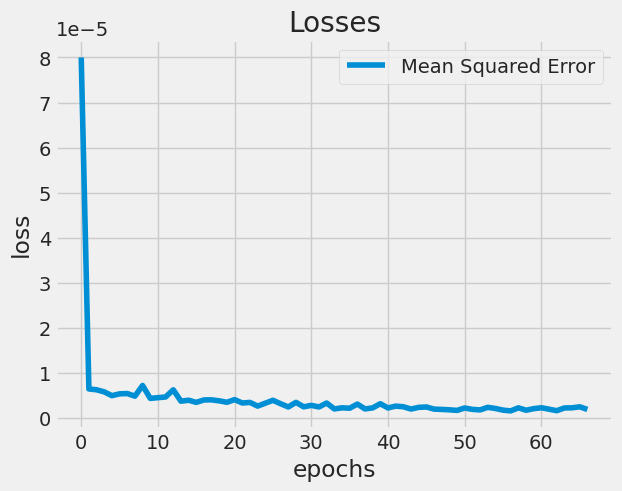

In [26]:
plt.plot(history.history["loss"])
plt.legend(['Mean Squared Error'])
plt.title("Losses")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

# Predection

In [27]:
x_test = []
y_test = []

for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])
    y_test.append(test_data[i, 0])
x_test, y_test = np.array(x_test), np.array(y_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [28]:
x_test.shape , y_test.shape

((739, 60, 1), (739,))

In [29]:
predictions = model_LSTM.predict(x_test)

24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step


In [30]:
predictions

array([[0.04055684],
       [0.03973215],
       [0.03919295],
       [0.03853499],
       [0.03723935],
       [0.03540665],
       [0.03500852],
       [0.03494591],
       [0.03463339],
       [0.03534805],
       [0.0368882 ],
       [0.03782156],
       [0.0373619 ],
       [0.03657872],
       [0.03583512],
       [0.03525781],
       [0.03392928],
       [0.03362093],
       [0.03370394],
       [0.03355145],
       [0.03192988],
       [0.03034756],
       [0.02960118],
       [0.02838941],
       [0.02800122],
       [0.02761363],
       [0.02729361],
       [0.02727557],
       [0.02719478],
       [0.02686765],
       [0.0260988 ],
       [0.02690788],
       [0.02789753],
       [0.02921901],
       [0.02975675],
       [0.03052167],
       [0.03124759],
       [0.03084315],
       [0.0307652 ],
       [0.03086272],
       [0.03183362],
       [0.03246707],
       [0.03283964],
       [0.03234575],
       [0.03210231],
       [0.03219691],
       [0.03198927],
       [0.031

In [31]:
predictions = scaler.inverse_transform(predictions)
predictions.shape

(739, 1)

In [32]:
predictions

array([[  52.91311 ],
       [  51.901417],
       [  51.239952],
       [  50.432796],
       [  48.84337 ],
       [  46.595108],
       [  46.106697],
       [  46.029896],
       [  45.64651 ],
       [  46.523216],
       [  48.4126  ],
       [  49.557606],
       [  48.993717],
       [  48.032944],
       [  47.120735],
       [  46.41252 ],
       [  44.782745],
       [  44.404472],
       [  44.506306],
       [  44.319237],
       [  42.329983],
       [  40.388874],
       [  39.473248],
       [  37.98671 ],
       [  37.510494],
       [  37.035023],
       [  36.642437],
       [  36.6203  ],
       [  36.521202],
       [  36.119892],
       [  35.17671 ],
       [  36.16924 ],
       [  37.3833  ],
       [  39.004425],
       [  39.664093],
       [  40.602463],
       [  41.49298 ],
       [  40.996838],
       [  40.90122 ],
       [  41.020836],
       [  42.21189 ],
       [  42.98898 ],
       [  43.446026],
       [  42.84015 ],
       [  42.541508],
       [  

### Root mean square error

In [33]:
y_test = scaler.inverse_transform([y_test])

RMSE = np.sqrt(np.mean( y_test - predictions )**2).round(2)
RMSE

36.49

### Visualize Predictions with The Data

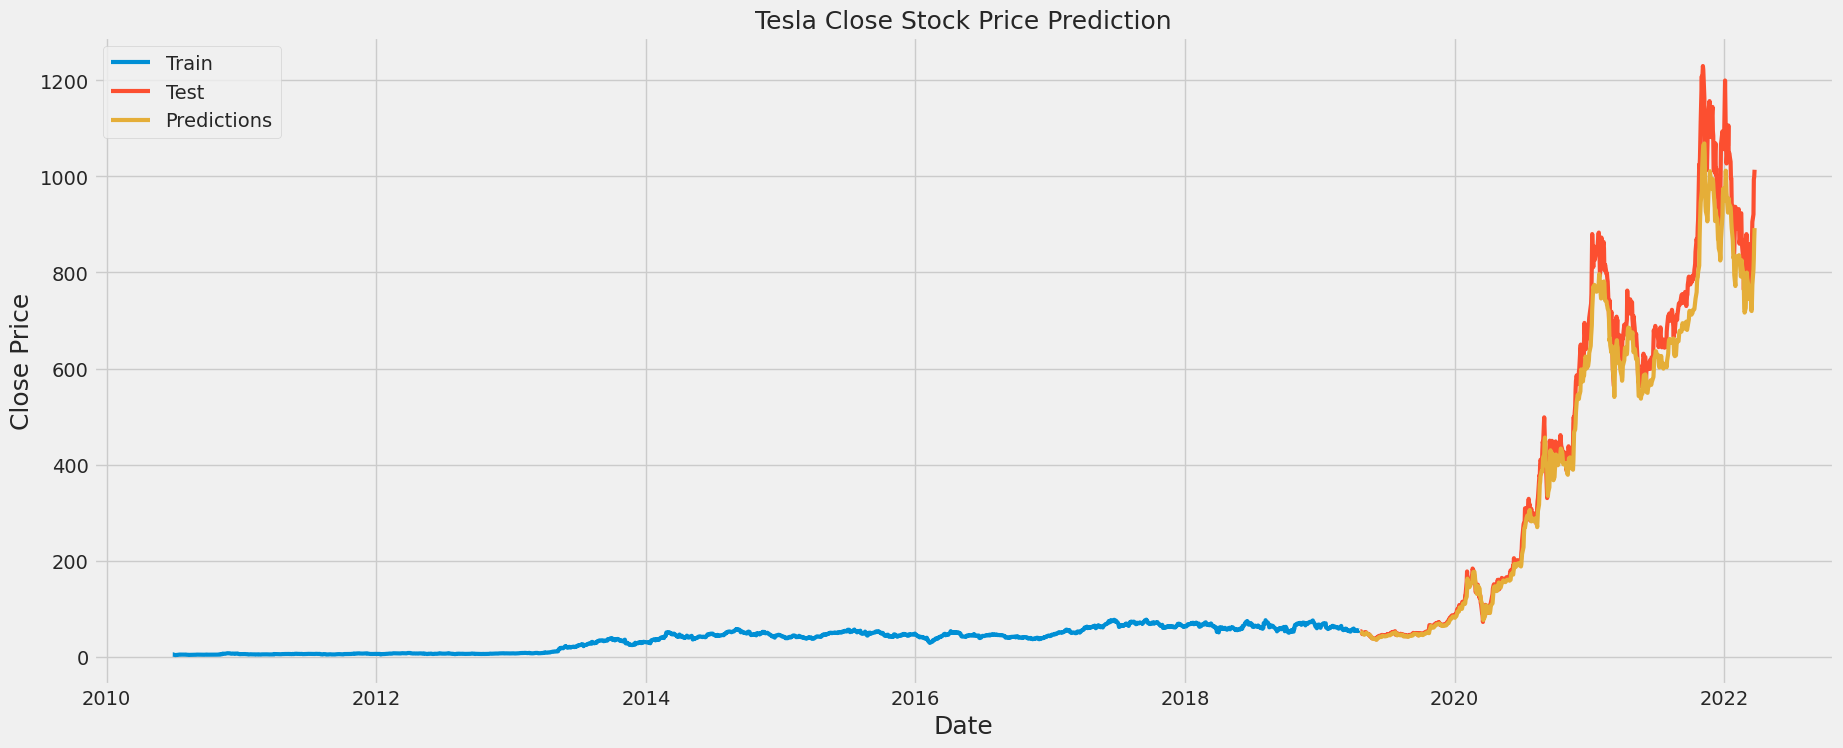

In [34]:
train = df.iloc[:train_size , 0:1]
test = df.iloc[train_size: , 0:1]
test['Predictions'] = predictions

plt.figure(figsize= (20, 8))
plt.title('Tesla Close Stock Price Prediction', fontsize= 18)
plt.xlabel('Date', fontsize= 18)
plt.ylabel('Close Price', fontsize= 18)
plt.plot(train['Close'], linewidth= 3)
plt.plot(test['Close'], linewidth= 3)
plt.plot(test["Predictions"], linewidth= 3)
plt.legend(['Train', 'Test', 'Predictions'])

# Forecast Next 30 Days

In [35]:
from datetime import timedelta

In [36]:
def insert_end(Xin, new_input):
    timestep = 60
    for i in range(timestep - 1):
        Xin[:, i, :] = Xin[:, i+1, :]
    Xin[:, timestep - 1, :] = new_input
    return Xin

In [37]:
future = 30
forcast = []
Xin = x_test[-1 :, :, :]
time = []
for i in range(0, future):
    out = model_LSTM.predict(Xin, batch_size=5)
    forcast.append(out[0, 0]) 
    print(forcast)
    Xin = insert_end(Xin, out[0, 0]) 
    time.append(pd.to_datetime(df.index[-1]) + timedelta(days=i))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
[0.7249309]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
[0.7249309, 0.69767255]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
[0.7249309, 0.69767255, 0.65820104]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
[0.7249309, 0.69767255, 0.65820104, 0.61657834]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
[0.7249309, 0.69767255, 0.65820104, 0.61657834, 0.57633024]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
[0.7249309, 0.69767255, 0.65820104, 0.61657834, 0.57633024, 0.53918135]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
[0.7249309, 0.69767255, 0.65820104, 0.61657834, 0.57633024, 0.53918135, 0.50601244]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
[0.7249309, 0.69767255, 0.65820104, 0.61657834, 0.57633024, 0.53918135, 0.50601244, 0.4771224]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
[0.7249309, 0.69767255, 0.65820104, 0.61657834, 0.57633024, 0.53918135, 0.50601244, 0.4771224, 0.45238945]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
[0.7249309, 0.69767255, 0.65820104, 0.61657834, 0.57633024, 0.53918135, 0.50601244

In [38]:
time

[Timestamp('2022-03-24 00:00:00'),
 Timestamp('2022-03-25 00:00:00'),
 Timestamp('2022-03-26 00:00:00'),
 Timestamp('2022-03-27 00:00:00'),
 Timestamp('2022-03-28 00:00:00'),
 Timestamp('2022-03-29 00:00:00'),
 Timestamp('2022-03-30 00:00:00'),
 Timestamp('2022-03-31 00:00:00'),
 Timestamp('2022-04-01 00:00:00'),
 Timestamp('2022-04-02 00:00:00'),
 Timestamp('2022-04-03 00:00:00'),
 Timestamp('2022-04-04 00:00:00'),
 Timestamp('2022-04-05 00:00:00'),
 Timestamp('2022-04-06 00:00:00'),
 Timestamp('2022-04-07 00:00:00'),
 Timestamp('2022-04-08 00:00:00'),
 Timestamp('2022-04-09 00:00:00'),
 Timestamp('2022-04-10 00:00:00'),
 Timestamp('2022-04-11 00:00:00'),
 Timestamp('2022-04-12 00:00:00'),
 Timestamp('2022-04-13 00:00:00'),
 Timestamp('2022-04-14 00:00:00'),
 Timestamp('2022-04-15 00:00:00'),
 Timestamp('2022-04-16 00:00:00'),
 Timestamp('2022-04-17 00:00:00'),
 Timestamp('2022-04-18 00:00:00'),
 Timestamp('2022-04-19 00:00:00'),
 Timestamp('2022-04-20 00:00:00'),
 Timestamp('2022-04-

### Create forecasted dataframe

In [39]:
forcasted_output = np.asanyarray(forcast)   
forcasted_output = forcasted_output.reshape(-1, 1) 
forcasted_output = scaler.inverse_transform(forcasted_output) 

In [40]:
forcasted_output = pd.DataFrame(forcasted_output)
date = pd.DataFrame(time)
df_result = pd.concat([date,forcasted_output], axis=1)
df_result.columns = "Date", "Forecasted"

## Forecasted tesla close price

In [41]:
df_result

,Date,Forecasted
0,2022-03-24,892.468994
1,2022-03-25,859.029846
2,2022-03-26,810.608154
3,2022-03-27,759.547546
4,2022-03-28,710.173157
5,2022-03-29,664.600769
6,2022-03-30,623.910828
7,2022-03-31,588.469910
8,2022-04-01,558.128784
9,2022-04-02,532.401550


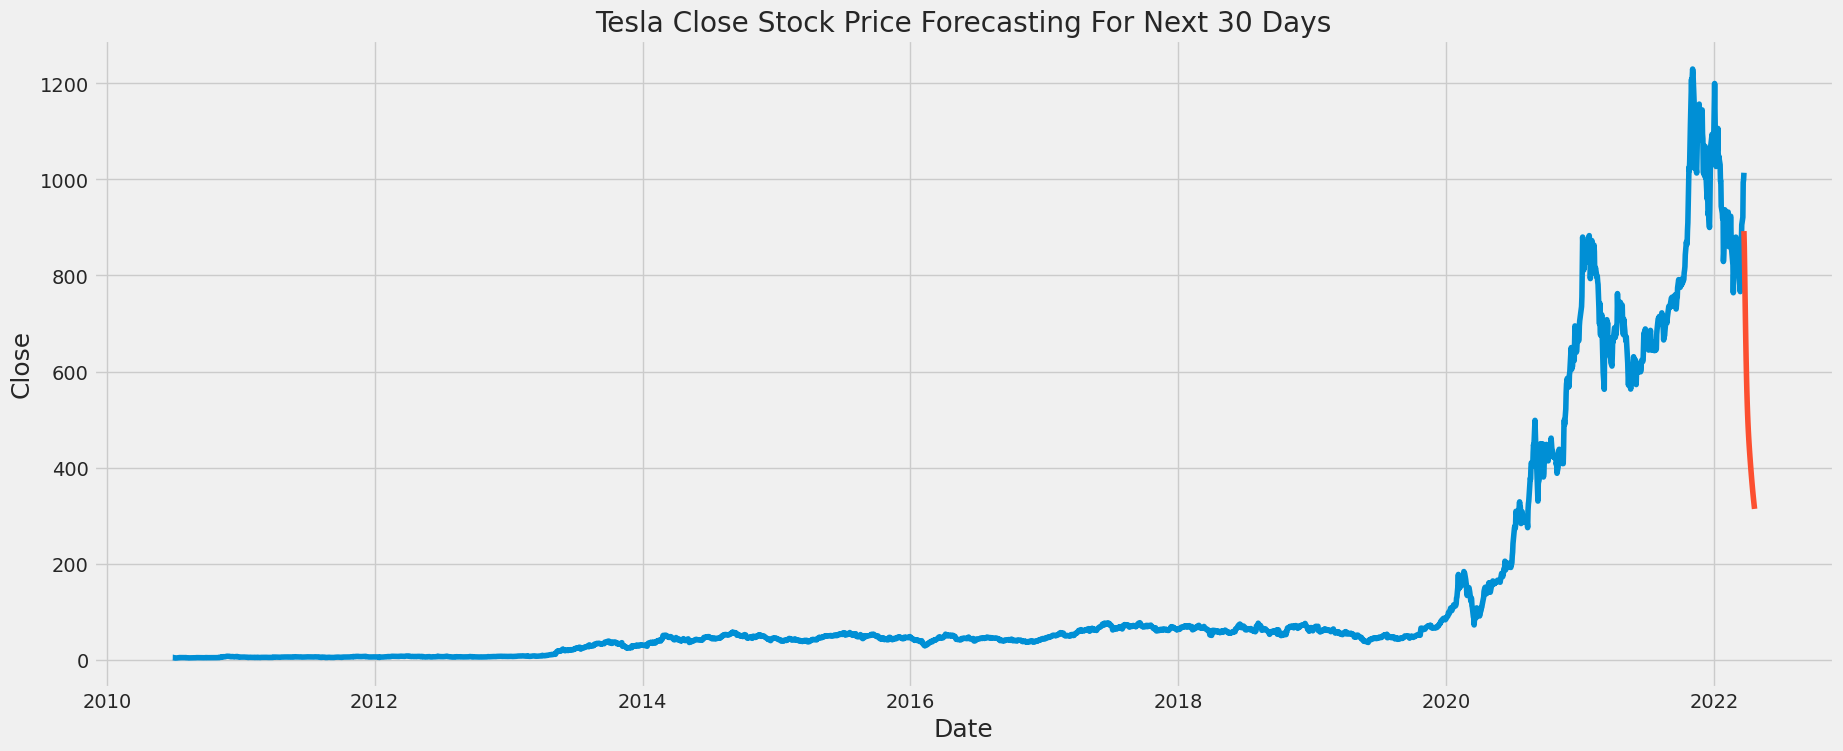

In [42]:
plt.figure(figsize=(20, 8))
plt.title('Tesla Close Stock Price Forecasting For Next 30 Days')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close' ,fontsize=18)
plt.plot(df['Close'])
plt.plot(df_result.set_index('Date')[['Forecasted']])